In [1]:
import EoN
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tqdm.autonotebook import tqdm
import time

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

/Users/agarbuno/anaconda2/envs/risknet/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
import sys
sys.path.append('/Users/agarbuno/github-repos/collaborations/covid/risk-networks/risknet')

In [3]:
%load_ext autoreload
%autoreload 2
import epimodels
import ensemble

In [4]:
# Load city-like network
net_size = '1e3'
edge_list = np.loadtxt('../data/networks/edge_list_SBM_%s.txt'%net_size, usecols = [0,1], dtype = int, skiprows = 1) 
G = nx.Graph([tuple(k) for k in edge_list])
N = len(G)

In [5]:
# Set city label
city_classes = ['hospital', 'healthcare', 'city']
city_classes_range = [range(int(float(net_size) * 0.005)), 
                 range(int(float(net_size) * 0.005), int(float(net_size) * 0.045)), 
                 range(int(float(net_size) * 0.045), N)]

cohort = defaultdict()
for node in tqdm(G.nodes):
    if node in city_classes_range[0]:
        cohort[node] = {'cohort': city_classes[0]}
    elif node in city_classes_range[1]:
        cohort[node] = {'cohort': city_classes[1]}
    else:
        cohort[node] = {'cohort': city_classes[2]}

In [6]:
nx.set_node_attributes(G, cohort)

In [7]:
# latent period distribution: E -> I (σ)
l = lambda k = 1.7, theta = 2: 2+np.random.gamma(k, theta)
# infectiousness duration outside hospitals: I -> . (γ)
g = lambda k = 1.5, theta = 2: 1+np.random.gamma(k, theta)
# infectiousness duration in hospitals: H -> . (γ')
gp = lambda k = 1.5, theta = 3: 1+np.random.gamma(k, theta)


# age structure King County, WA: https://datausa.io/profile/geo/king-county-wa#demographics
# we use the age classes: 0--19, 20--44, 45--64, 65--74, >= 75
age_classes = np.asarray([0.2298112587,0.3876994201,0.2504385036,0.079450985,0.0525998326])

# age distribution in working population: 20--44 and 45--64
age_classes_working = np.asarray([0.3876994201,0.2504385036])/sum([0.3876994201,0.2504385036])

# age-dependent hospitalization and recovery rates

fh = np.asarray([0.02, 0.17, 0.25, 0.35, 0.45])
fd = np.asarray([1e-15, 0.001, 0.005, 0.02, 0.05])
fdp = np.asarray([1e-15, 0.001, 0.01, 0.04, 0.1])

# hospitalization fraction (a...age class integers to refer to 0--19, 20--44, 45--64, 65--74, >= 75)

h = lambda a, beta = 4: np.random.beta(beta*fh[a]/(1-fh[a]), b = beta)
d = lambda a, beta = 4: np.random.beta(beta*fd[a]/(1-fd[a]), b = beta)
dp = lambda a, beta = 4: np.random.beta(beta*fdp[a]/(1-fdp[a]), b = beta)

# transmission

beta0 = 0.05
betap0 = 0.75*beta0


In [8]:
age_classes[1:]

array([0.38769942, 0.2504385 , 0.07945099, 0.05259983])

In [9]:
attrs_dict = defaultdict()
np.random.seed(1)

for kk, node in tqdm(enumerate(list(G.nodes())), desc = 'Building properties'):
    age_group = np.random.choice(len(age_classes), p = age_classes)
    g_samp    = g()
    gp_samp   = gp()
    h_samp    = h(age_group)
    d_samp    = d(age_group)
    dp_samp   = dp(age_group)

    while h_samp + d_samp > 1:   
        h_samp    = h(age_group)
        d_samp    = d(age_group)

    attrs = {
        'age_group': age_group,
        'sigma': l(),
        'gamma': g_samp,
        'gammap': gp_samp,
        'theta' : (1 - h_samp - d_samp) * g_samp,
        'delta' : h_samp * g_samp,
        'mu'    : d_samp * g_samp,
        'thetap': (1 - dp_samp) * gp_samp,
        'mup'   : dp_samp * gp_samp
    }
    
    attrs_dict[node] = attrs

In [10]:
nx.set_node_attributes(G, attrs_dict)

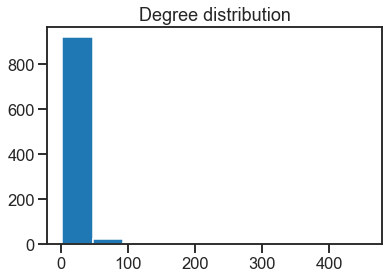

In [11]:
plt.hist(np.array(list(dict(G.degree).values())));
plt.title(r'Degree distribution');

In [12]:
epistatic = epimodels.static(G, N)

In [13]:
epistatic.init(beta = 0.3, het = True)
epistatic.betap = 0.75 * epistatic.beta

In [14]:
# infected = range(200)
infected = np.random.randint(N, size = 50)
# infected = np.random.randint(city_classes_range[-1][0], city_classes_range[-1][-1], size = 50)
epistatic.init_infected(infected)

In [15]:
nsims = 50
sims  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for kk in tqdm(np.arange(nsims), desc = 'Simulations'):
    sim = epistatic.simulate(return_statuses)
    sims.append(sim)

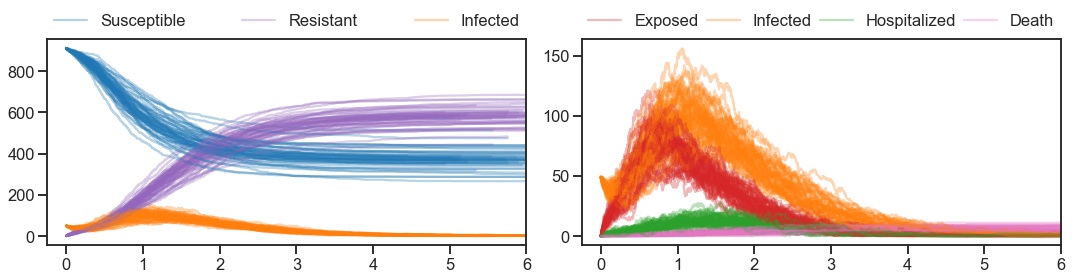

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .32

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for ax in axes:
    ax.set_xlim(-.25, 6)

plt.tight_layout()

In [17]:
ylims = [np.empty(2,), np.empty(2,)]
ylims[0] = axes[0].get_ylim()
ylims[1] = axes[1].get_ylim()

In [18]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [19]:
y0 = np.hstack((S, E, I, H, R, D))
T = 10
t = np.linspace(0,T,201)

In [20]:
start_time = time.time()

epistatic.set_solver(T = T, dt = .1)
ke = epistatic.solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Runtime: 00:00:01


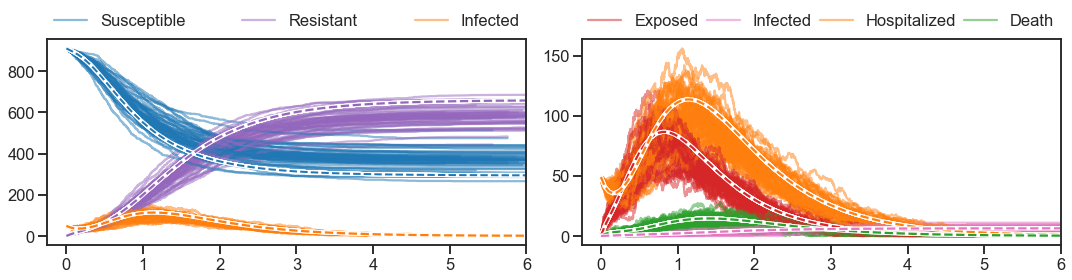

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .5

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)
    
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'C6', linestyle = '--')
    
axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for kk, ax in enumerate(axes):
    ax.set_xlim(-.25, 6)
    ax.set_ylim(ylims[kk])
    
    
plt.tight_layout()

In [22]:
tqdm.write('Number of probabilities exceeding upper bound: %s'%(ke.y.reshape(6,-1,201).max(axis = 0) > 1.0 + 1e-12).sum())

Number of probabilities exceeding upper bound: 0


In [23]:
states = ['Susceptible', 'Exposed', 'Infected', 'Hospitalized', 'Resistant', 'Dead']
colors = ['C0', 'C3', 'C1', 'C2', 'C4', 'C6']

In [24]:
# fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

# alpha = .1

# # for mm in tqdm(range(6), desc = 'Simulations'):
# for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha, color = 'silver');
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,city_classes_range[0]], alpha = alpha + .5, color = colors[state]);
#     ax.set_xlabel(states[state])
#     ax.set_xlim(-.25, 6)

# plt.suptitle('Hospital', fontsize = 30, y =  1.05)
# plt.tight_layout()

In [25]:
# fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

# alpha = .1

# # for mm in tqdm(range(6), desc = 'Simulations'):
# for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha, color = 'silver');
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,city_classes_range[1]], alpha = alpha + .5, color = colors[state]);
#     ax.set_xlabel(states[state])
#     ax.set_xlim(-.25, 6)
    
# plt.suptitle('Healthcare', fontsize = 30, y =  1.05)

# plt.tight_layout()

In [26]:
# fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

# alpha = .1

# # for mm in tqdm(range(6), desc = 'Simulations'):
# for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha + .2, color = 'silver');
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,city_classes_range[2]], alpha = alpha, color = colors[state]);
#     ax.set_title(states[state])
#     ax.set_xlim(-.25, 6)

# plt.suptitle('City', fontsize = 30, y =  1.05)
    
# plt.tight_layout()

In [27]:
nS = (ke.y.reshape(6, -1, 201)[0][:,-1] <= 1e-3)

In [28]:
# fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

# alpha = .1

# # for mm in tqdm(range(6), desc = 'Simulations'):
# for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha + .2, color = 'silver');
#     ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,nS], alpha = alpha, color = colors[state]);
#     ax.set_title(states[state])
#     ax.set_xlim(-.25, 6)

# plt.suptitle('City: tracing (?)', fontsize = 30, y =  1.05)
    
# plt.tight_layout()

# Closures

In [29]:
states_plt = ['Susceptible', 'Exposed', 'Infected', 'Hospitalized', 'Resistant', 'Dead']
colors_plt = ['C0', 'C3', 'C1', 'C2', 'C4', 'C6']

In [30]:
Gstar = G.copy()

In [31]:
M = 50

**TODO**: Make a list outside of the module and pass it to the generator

In [32]:
Gs = list()

for mm in tqdm(range(M), 'List of graphs'):
    Gmm = Gstar.copy()
    np.random.seed(mm)
    attrs_dict = defaultdict()
    
    for kk, node in enumerate(list(Gstar.nodes())):
        
        cohort = Gstar.nodes[node]['cohort']
        age_group = Gstar.nodes[node]['age_group']

        g_samp    = g()
        gp_samp   = gp()
        h_samp    = h(age_group)
        d_samp    = d(age_group)
        dp_samp   = dp(age_group)

        while h_samp + d_samp > 1:   
            h_samp    = h(age_group)
            d_samp    = d(age_group)

        attrs = {
            'cohort' : cohort,
            'age_group': age_group,
            'sigma': l(),
            'gamma': g_samp,
            'gammap': gp_samp,
            'theta' : (1 - h_samp - d_samp) * g_samp,
            'delta' : h_samp * g_samp,
            'mu'    : d_samp * g_samp,
            'thetap': (1 - dp_samp) * gp_samp,
            'mup'   : dp_samp * gp_samp
        }
    
        attrs_dict[node] = attrs
        
    nx.set_node_attributes(Gmm, attrs_dict)
    Gs.append(Gmm)
    

In [33]:
ens = ensemble.epiens(M, Gs, N)
np.random.seed(1)
ens.init(beta = epistatic.beta, hom = False)

In [34]:
y0 = np.hstack((S, E, I, H, R, D))
y0 = np.tile(y0, ens.M).reshape(ens.M, -1)
T = 10
t = np.linspace(0,T,201)
ens.set_solver(T = T, dt = .1)

In [35]:
start_time = time.time()

ke = ens.ens_solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:46


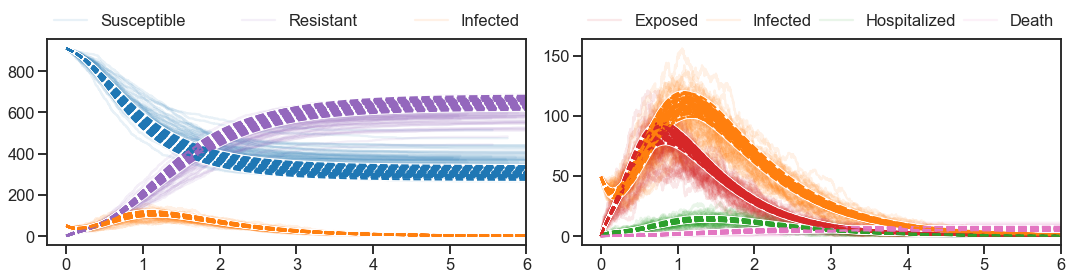

In [36]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .1

for sim in tqdm(sims, desc = 'Simulations', position = 0):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    
alpha = .9

for mm in tqdm(range(M), desc = 'Simulations', position = 0):
    times, states = sim.summary()
    
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'white', linewidth = 4)
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'white', linewidth = 4)
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'white', linewidth = 4)
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'white', linewidth = 4)
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'white', linewidth = 4)

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for kk, ax in enumerate(axes):
    ax.set_xlim(-.25, 6)
    ax.set_ylim(ylims[kk])

plt.tight_layout()

### **Case 2.** This solves the whole system with simple Euler steps, again with the individual-based closure. 

In [37]:
ens.set_solver(T = T, dt = np.diff(t).min())

In [38]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:15


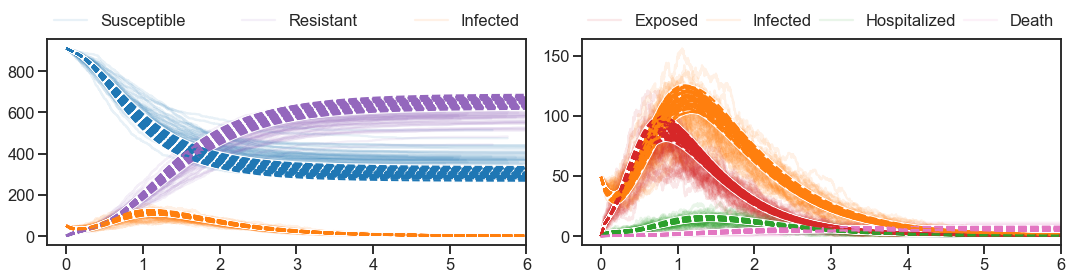

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .1

for sim in tqdm(sims, desc = 'Simulations', position = 0):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    
alpha = .9

for mm in tqdm(range(M), desc = 'Simulations', position = 0):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'white', linewidth = 4)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'white', linewidth = 4)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'white', linewidth = 4)

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for kk, ax in enumerate(axes):
    ax.set_xlim(-.25, 6)
    ax.set_ylim(ylims[kk])

plt.tight_layout()

### **Case 3.** This solves the whole system with simple Euler steps, now with the pair-based covariance closure. 

In [40]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t, closure = 'covariance')

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:15


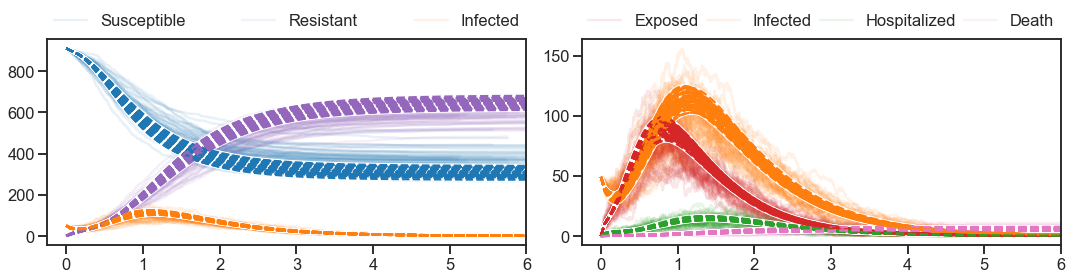

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .1

for sim in tqdm(sims, desc = 'Simulations', position = 0):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    
alpha = .9

for mm in tqdm(range(M), desc = 'Simulations', position = 0):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'white', linewidth = 4)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'white', linewidth = 4)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'white', linewidth = 4)

alpha = .9

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for kk, ax in enumerate(axes):
    ax.set_xlim(-.25, 6)
    ax.set_ylim(ylims[kk])

plt.tight_layout()

### **Case 4.** This solves the whole system with simple Euler steps, now with the pair-based correlation closure. 

In [42]:
t = np.linspace(0,T,201)
ens.set_solver(T = T, dt = np.diff(t).min())

In [45]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t, closure = 'correlation')

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:18


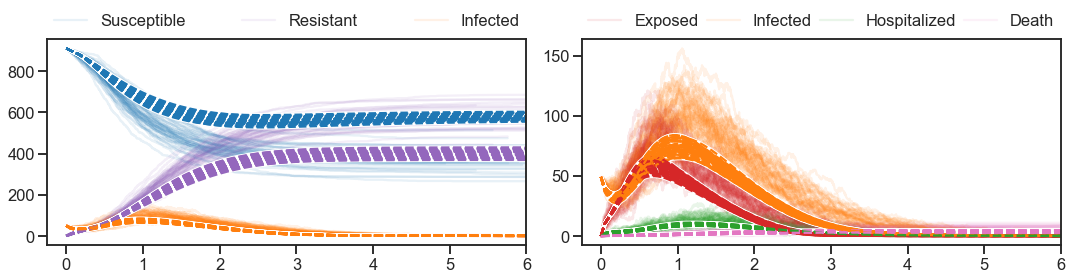

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .1

for sim in tqdm(sims, desc = 'Simulations', position = 0):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    
alpha = .9

for mm in tqdm(range(M), desc = 'Simulations', position = 0):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'white', linewidth = 4)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'white', linewidth = 4)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'white', linewidth = 4)
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'white', linewidth = 4)

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for kk, ax in enumerate(axes):
    ax.set_xlim(-.25, 6)
    ax.set_ylim(ylims[kk])

plt.tight_layout()